<a href="https://colab.research.google.com/github/rajuvarla/PGCP/blob/main/Image_captioning_G4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
import random
from tensorflow.keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [25]:
from keras.utils import np_utils

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
images_dir = os.listdir("../content/drive/MyDrive/AMIL_PGCP/Flickr8k_Dataset/Flicker8k_Dataset")

images_path = '../content/drive/MyDrive/AMIL_PGCP/Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = '../content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr8k.token.txt'
train_path = '../content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '../content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '../content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [28]:
images = os.listdir(images_path)
print("The number of jpg flies in Flicker8k: {}".format(len(images)))

The number of jpg flies in Flicker8k: 8091


In [29]:
print("The number of jpg flies in Flicker8k: {}".format(len(images_dir)))

The number of jpg flies in Flicker8k: 8091


In [30]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

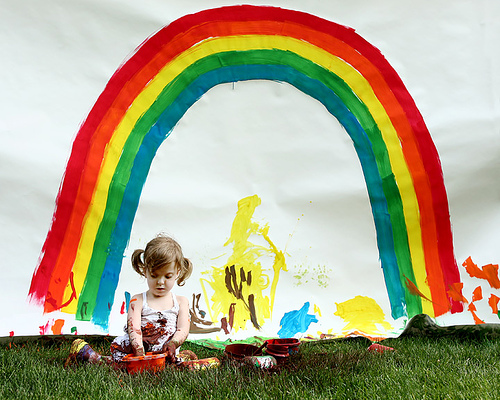

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [31]:
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])
    #print(temp[0])

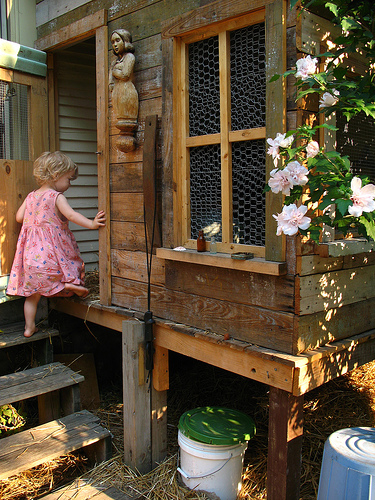

In [32]:
from IPython.display import Image
Image('../content/drive/MyDrive/AMIL_PGCP/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

In [33]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(captions_path)

In [34]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [35]:
# delete unwanted 
del captions_dict

In [36]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"1000268201_693b08cb0e" : startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [37]:
len(new_captions_dict)

8092

In [38]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]

In [39]:
caption_images_list[0]

'1024138940_f1fefbdce1'

In [40]:
len(caption_images_list)

8091

In [41]:
train_validate_images = caption_images_list[0:8081]

In [42]:
test_images = caption_images_list[8081:8091]
test_images

['3667404919_b273df57e4',
 '3665569615_9a71c4b6e4',
 '3677318686_b018862bb7',
 '3677302645_8cd3fac70d',
 '3676561090_9828a9f6d0',
 '3677514746_26f5588150',
 '3677239603_95865a9073',
 '367673290_f8799f3a85',
 '3677613006_4689cb8e4e',
 '3676788491_01e9bc5f15']

In [44]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [45]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

In [47]:
# extracting image features for train_validate_images
train_validate_features = extract_features(images_path, train_validate_images)

553476096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [48]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

1024138940_f1fefbdce1 : [[0. 0. 0. ... 0. 0. 0.]]


In [49]:
len(train_validate_features)

8081

In [50]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [51]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [52]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

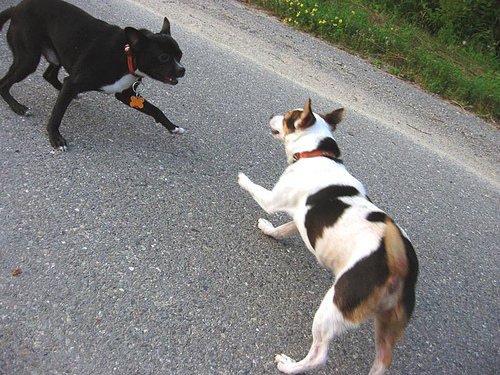

In [54]:
Image(images_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [57]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [58]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [59]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [60]:
len(train_x1)

72292

In [61]:
len(validate_x1)

10248

In [62]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1146880     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

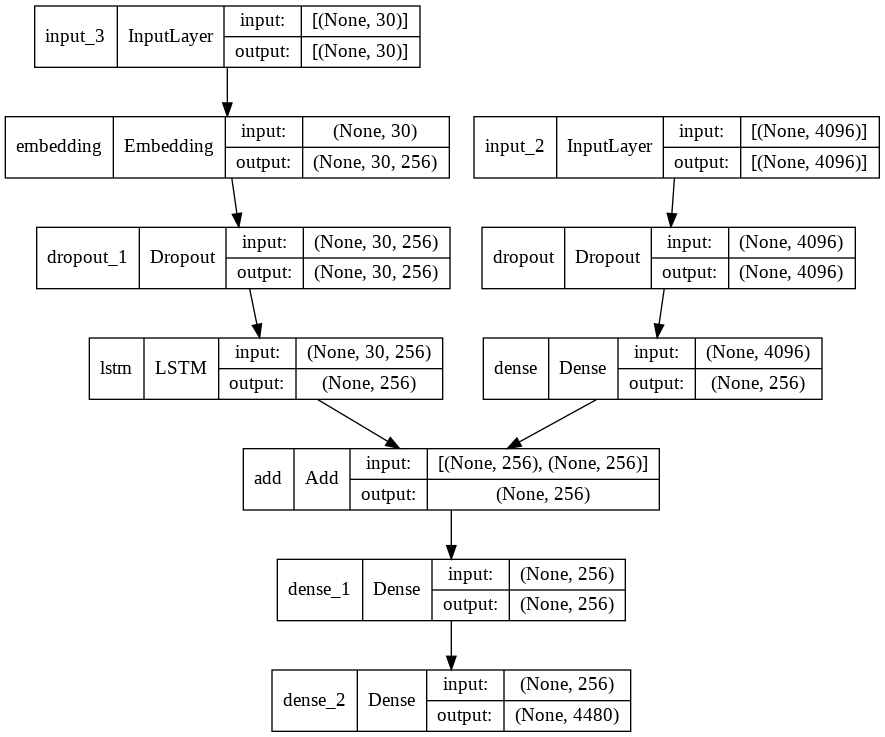

In [63]:
plot_model(model, to_file='model.png', show_shapes=True)

In [64]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [65]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72292, 4096)
shape of train_x2  (72292, 30)
shape of train_y  (72292, 4480)

shape of validate_x1  (10248, 4096)
shape of validate_x2  (10248, 30)
shape of validate_y  (10248, 4480)


In [66]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
2260/2260 [==============================] - 529s 231ms/step - loss: 5.0321 - val_loss: 4.4780


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/20
2260/2260 [==============================] - 493s 218ms/step - loss: 4.1806 - val_loss: 4.2705
Epoch 3/20
2260/2260 [==============================] - 496s 219ms/step - loss: 3.8542 - val_loss: 4.2370
Epoch 4/20
2260/2260 [==============================] - 499s 221ms/step - loss: 3.6324 - val_loss: 4.2923
Epoch 5/20
2260/2260 [==============================] - 494s 219ms/step - loss: 3.4521 - val_loss: 4.3812
Epoch 6/20
2260/2260 [==============================] - 496s 219ms/step - loss: 3.3093 - val_loss: 4.4012
Epoch 7/20
2260/2260 [==============================] - 501s 222ms/step - loss: 3.1829 - val_loss: 4.5029
Epoch 8/20
2260/2260 [==============================] - 499s 221ms/step - loss: 3.0732 - val_loss: 4.6516
Epoch 9/20
2260/2260 [==============================] - 498s 221ms/step - loss: 2.9808 - val_loss: 4.7226
Epoch 10/20
2260/2260 [==============================] - 503s 223ms/step - loss: 2.9008 - val_loss: 4.8948
Epoch 11/20
2260/2260 [======================

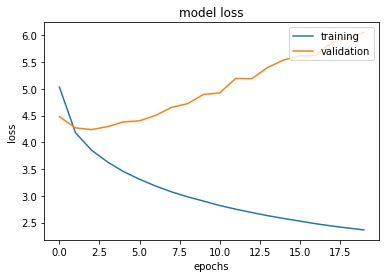

In [67]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [68]:
# saving the model with last parameter 
model.save('./latest_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [69]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [70]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [75]:
from tensorflow.keras.models import load_model
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq brown dog is running through the sand endseq

Actual caption ->  startseq two different breeds of brown and white dogs play on the beach endseq
*********************************************************************

Predicted caption ->  startseq brown dog is running through the snow endseq

Actual caption ->  startseq brown dog chases the water from sprinkler on lawn endseq
*********************************************************************

Predicted caption ->  startseq man in black coat is snowboarding endseq

Actual caption ->  startseq man in hat is displaying pictures next to skier in blue hat endseq
*********************************************************************

Predicted caption ->  startseq man in yellow jacket is riding on the ground as she steps on the beach endseq

Actual caption ->  startseq man drilling hole in the ice endseq
*********************************************************************

Predicted caption ->  startseq dog is